# Importing the necessary libraries:

# pandas, numpy, scipy


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import math
from matplotlib import style
import seaborn as sns
from ipywidgets import *
import itable

plt.style.use('ggplot')


# Merging the 3 sheets into a single DataFrame

In [3]:
data_all = pd.concat(pd.read_excel('histo_cotation_2016_2017_2018.xlsx', sheet_name=None), ignore_index=True, sort=True)



In [4]:
# UNCOMMEN TO TEST
#data_all.head()
#data_all

# Cleaning BIAT Data

In [5]:
biat_data = data_all[data_all['VALEUR'] == 'BIAT']

biat_data = biat_data.assign(CLOTURE=pd.to_numeric(biat_data['CLOTURE']))

rendement = np.zeros_like(biat_data['CLOTURE'])
biat_data = biat_data.assign(RENDEMENT=rendement)
index_nb_trans_zero = biat_data.index[biat_data['NB_TRANSACTION'] == 0].tolist()
biat_data = biat_data.drop(index_nb_trans_zero)
biat_data.loc[biat_data['NB_TRANSACTION'] == 0,]
biat_data['SEANCE'] = biat_data['SEANCE'].astype(str)


In [6]:
# UNCOMMENT TO TEST
biat_data.head()

,CAPITAUX,CLOTURE,CODE,DIVIDENDES,GROUPE,IND_RES,NB_TRANSACTION,OUVERTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,RENDEMENT,SEANCE,VALEUR
5,21948.3,76.90,180045,NaN,11,NaN,6,76.35,76.35,77,286,0.0,2016-04-01 00:00:00,BIAT
499,24925,76.00,180045,NaN,11,NaN,5,76.9,76,76.9,325,0.0,2016-05-01 00:00:00,BIAT
993,156954,75.99,180045,NaN,11,NaN,19,75,75,75.99,2092,0.0,2016-06-01 00:00:00,BIAT
1487,14138.5,77.90,180045,NaN,11,NaN,9,75.99,75.99,77.9,186,0.0,2016-07-01 00:00:00,BIAT
1981,191524,76.27,180045,NaN,11,NaN,15,77.89,76.1,77.89,2498,0.0,2016-08-01 00:00:00,BIAT


## ADDING DIVIDEND

In [7]:
biat_data['DIVIDENDE'] = 0.0
biat_data.loc[biat_data['SEANCE'] == '15/06/2016', 'DIVIDENDE'] = 4.000
biat_data.loc[biat_data['SEANCE'] == '2017-06-12 00:00:00', 'DIVIDENDE'] = 4.000
biat_data.loc[biat_data['SEANCE'] == '14/05/18', 'DIVIDENDE'] = 4.250

In [87]:
dbiat = biat_data[['VALEUR','CAPITAUX','SEANCE','CLOTURE','NB_TRANSACTION','RENDEMENT','DIVIDENDE']].head(10)
pt1 = itable.PrettyTable(dbiat,tstyle=itable.TableStyle(theme="theme1"), center=True, header_row=True)
pt1.set_cell_style(font_weight="bold", color="purple", background_color="pink", rows=[0,1,2,3,4,5,6,7,8,9], cols=[0,1,2,3,4,5,6])
pt1.set_col_header_style(background_color="grey", font_weight="bold", indices=[0,1,2,3,4,5,6])
pt1

,VALEUR,CAPITAUX,SEANCE,CLOTURE,NB_TRANSACTION,RENDEMENT,DIVIDENDE
5,BIAT,21948.34,2016-04-01 00:00:00,76.9,6,nan,0.0
499,BIAT,24925,2016-05-01 00:00:00,76.0,5,-0.011772536225267236,0.0
993,BIAT,156954.45,2016-06-01 00:00:00,75.99,19,-0.00013158760463759573,0.0
1487,BIAT,14138.46,2016-07-01 00:00:00,77.9,9,0.02482420019500911,0.0
1981,BIAT,191523.72,2016-08-01 00:00:00,76.27,15,-0.021146276700555508,0.0
2475,BIAT,100305.42,2016-11-01 00:00:00,76.5,12,0.0030110646563429803,0.0
2969,BIAT,62258.34,2016-12-01 00:00:00,76.2,6,-0.00392927813988955,0.0
3461,BIAT,2366.65,13/01/2016,76.33,4,0.0017045831177782945,0.0
3953,BIAT,26115.12,15/01/2016,76.36,4,0.00039295304716795707,0.0
4445,BIAT,15353.52,18/01/2016,76.61,7,0.0032686176711827475,0.0


# Variables calculations

In [9]:
rendemnt_cal = np.log((biat_data['CLOTURE'] + biat_data['DIVIDENDE'])/(biat_data['CLOTURE'].shift(1)))

biat_data['RENDEMENT'] = rendemnt_cal

rt = np.nanmean(biat_data['RENDEMENT'])

sum_r_rbarre = np.sum((biat_data['RENDEMENT'].replace(np.nan, 0.0) - rt)**2)

sigma_squared = 250/(len(biat_data)-1) * sum_r_rbarre

sigma = np.sqrt(sigma_squared)

mu = 0.5 * sigma_squared + rt *250


In [10]:
# UNCOMMENT TO TEST

variables = { 'rt': rt, 'sigma_squared':sigma_squared, 'sigma':sigma, 'mu':mu}
for variable, value in variables.items():
    print(variable + " = " + str(value))

rt = 0.0004389936061045819
sigma_squared = 0.06750287285494198
sigma = 0.2598131498884188
mu = 0.14349983795361645


# L-JUNG - BOX autocorrelation test

In [11]:
acorr_ljungbox(biat_data['RENDEMENT'].replace(np.nan, 0.0), lags= 5)
acorr_ljungbox(biat_data['RENDEMENT'].replace(np.nan, 0.0), lags= 10)


(array([0.02962876, 0.03173135, 0.5501539 , 1.00698674, 2.14741625,
        2.16486974, 2.41513137, 3.24435629, 3.4890722 , 3.83927785]),
 array([0.86333528, 0.98425952, 0.90774246, 0.90873473, 0.82839408,
        0.90392807, 0.93335104, 0.91810019, 0.94172156, 0.95430627]))

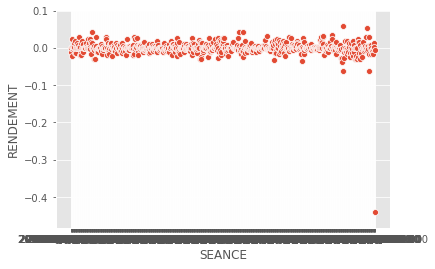

In [12]:
sns.scatterplot(x = 'SEANCE', y = 'RENDEMENT',data=biat_data)
plt.show()

# Noramlity Test

In [13]:
stats.shapiro(biat_data['RENDEMENT'].replace(np.nan, 0.0))

(0.5609124898910522, 0.0)

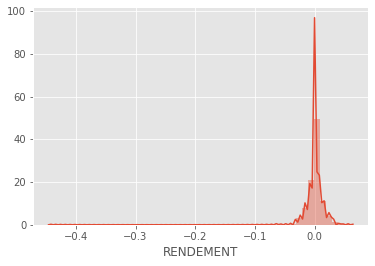

In [58]:
sns.distplot(biat_data['RENDEMENT'].replace(np.nan, 0.0), hist = True);

# Calcul de prix de l'option par l'equation Black & Scholes

In [15]:
def modelBlackAndScholes(s0,k,interest_rate,sigma_squared,PorC):
    
    d1 = (np.log(s0/k) + (interest_rate + 0.5 * sigma_squared)) * 1/np.sqrt(sigma_squared)
    d2 = d1 - np.sqrt(sigma_squared)
    if(PorC=='c'):
        op = s0 * stats.norm.cdf(d1) - k * (np.exp(-interest_rate)) * stats.norm.cdf(d2)
    elif(PorC=='p'):
        op  = k * np.exp(-interest_rate) * stats.norm.cdf(-d2) - s0 * stats.norm.cdf(-d1)
    
    
    return op

# Calcul de prix de l'option par simulation de Monte Carlo

In [17]:
def modelBS_simulation(N,sigma_squared,k,interest_rate):
    
    normal = np.random.normal(size=N)
    s = s0 * np.exp((interest_rate - sigma_squared/2) + np.sqrt(sigma_squared) * normal)
    xx = np.maximum((s - k), 0)
    op = np.mean(xx) * np.exp(-interest_rate)
    
    return op

# Calcul de prix de l'option par le modèle de Cox, Ross et Rubinstein

In [21]:
def modelCRR(K,T,S,sig,r,N,PorC):
    
    dt=T/N;
    dxu=np.exp(sig*np.sqrt(dt));
    dxd=np.exp(-sig*np.sqrt(dt));
    pu=((np.exp(r*dt))-dxd)/(dxu-dxd);
    pd=1-pu;
    disc=np.exp(-r*dt);

    St = [0] * (N+1)
    C = [0] * (N+1)
    
    St[0]=S*dxd**N;
    
    for j in range(1, N+1): 
        St[j] = St[j-1] * dxu/dxd;
    
    for j in range(1, N+1):
        if PorC == 'p':
            C[j] = max(K-St[j],0);
        elif PorC == 'c':
            C[j] = max(St[j]-K,0);
    
    for i in range(N, 0, -1):
        for j in range(0, i):
            C[j] = disc*(pu*C[j+1]+pd*C[j]);
            
    return C[0]

# Testing the results

In [47]:
s0 = biat_data.iloc[-1]['CLOTURE']
k = 125
i = 0.07
T = 1
N_values = [100,1000,10000]
crr_results = []
bs_simulations = []
for n in N_values:
    crr_results.append(round(modelCRR(k,T,s0,sigma,i,n,'c'),4))
    bs_simulations.append(round(modelBS_simulation(n,sigma_squared,k,i),4))
    


In [120]:
dfbs = pd.DataFrame(columns=np.array(["Direct BS Equation",str(round(modelBlackAndScholes(s0,k,i,sigma_squared,'c'),4))]))
pt2 = itable.PrettyTable(dfbs,tstyle=itable.TableStyle(theme="theme1"), center=True)
pt2.set_col_header_style(background_color="grey", font_weight="bold", indices=[0])
pt2.set_col_header_style(background_color="pink", font_weight="bold", indices=[1])
pt2

Direct BS Equation,13.7305


In [94]:
bs_direct = round(modelBlackAndScholes(s0,k,i,sigma_squared,'c'),4)
bs_sim = round(modelBS_simulation(100000,sigma_squared,k,i),4)
df = pd.DataFrame({"Model":["CRR","BS_Sim"], "N=100":[crr_results[0],bs_simulations[0]], "N=1000":[crr_results[1],bs_simulations[1]], "N=10000":[crr_results[2],bs_simulations[2]]
                  ,"N=100000":[np.NaN,bs_sim], "Model ERROR": [round(bs_direct - crr_results[2],5),round(bs_direct - bs_sim,5)]})
pt = itable.PrettyTable(df,tstyle=itable.TableStyle(theme="theme1"), center=True)
pt.set_cell_style(font_weight="bold", color="purple", background_color="pink", rows=[0,1], cols=[1,2,3,4,5])
pt.set_cell_style(font_weight="bold", color="black", background_color="grey", rows=[0,1], cols=[0])
pt.set_col_header_style(background_color="grey", font_weight="bold", indices=[0,1,2,3,4,5])
pt.set_row_header_style(font_weight="bold", indices=[0,1])
pt

Model,N=100,N=1000,N=10000,N=100000,Model ERROR
CRR,13.7246,13.7318,13.7307,nan,-0.0002
BS_Sim,14.6282,14.93,13.5564,13.7309,-0.0004
